In [13]:
!pip install pytorch-forecasting
!pip install torch torchvision torchaudio
!pip install optuna

Install and Import Libraries

In [14]:
# Install missing dependencies (uncomment if needed)
# !pip install optuna lightning

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from lightning.pytorch import Trainer, LightningModule
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


Load and Preprocess Data

In [15]:
# Load Data
train_file = "..\\Data\\Train\\trains1990s.csv"
df = pd.read_csv(train_file, parse_dates=['observation_date'])

# Rename Columns
df.columns = df.columns.str.replace('.', '_', regex=False)
df.rename(columns={'observation_date': 'Date', 'fred_PCEPI': 'Inflation'}, inplace=True)
df['time_idx'] = range(len(df))  # Numerical time index

# Normalize Inflation Data using StandardScaler
scaler = StandardScaler()
df['Inflation'] = scaler.fit_transform(df[['Inflation']])

# Split Data into Train & Validation (80% train, 20% validation)
split_idx = int(len(df) * 0.8)
train_df, val_df = df.iloc[:split_idx], df.iloc[split_idx:]


<ipython-input-15-a64bca591546>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(train_file, parse_dates=['observation_date'])


Function to Create Sequences

In [16]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i: i + seq_length])
        ys.append(data[i + seq_length])
    return np.array(xs), np.array(ys)

sequence_length = 12  # Use past 12 months to predict next step
X_train, y_train = create_sequences(train_df["Inflation"].values, sequence_length)
X_val, y_val = create_sequences(val_df["Inflation"].values, sequence_length)

# Convert to Torch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(-1)

# DataLoaders
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)


Define GRU Model using PyTorch Lightning

In [17]:
class GRUModel(LightningModule):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1, learning_rate=0.001):
        super(GRUModel, self).__init__()
        self.save_hyperparameters()  # Saves hyperparameters for logging
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.loss_fn = nn.MSELoss()

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # Take the last output
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.loss_fn(y_pred, y)
        self.log("train_loss", loss, prog_bar=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.loss_fn(y_pred, y)
        self.log("val_loss", loss, prog_bar=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.hparams.learning_rate)


Hyperparameter Tuning with Optuna

In [18]:
def objective(trial):
    try:
        print(f"Trial {trial.number} starting...")

        # Suggest hyperparameters
        hidden_size = trial.suggest_int("hidden_size", 32, 256)
        num_layers = trial.suggest_int("num_layers", 1, 4)
        learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)

        # Define model
        model = GRUModel(input_size=1, hidden_size=hidden_size, num_layers=num_layers, output_size=1, learning_rate=learning_rate)

        # Define early stopping
        early_stopping = EarlyStopping(monitor="val_loss", patience=5, mode="min")

        trainer = Trainer(
            max_epochs=50,
            accelerator="auto",
            callbacks=[early_stopping],
            enable_checkpointing=False,  # Don't save checkpoints in tuning phase
            log_every_n_steps=10
        )

        # Train model
        trainer.fit(model, train_loader, val_loader)

        # Get validation loss
        best_val_loss = trainer.callback_metrics.get("val_loss")
        if best_val_loss is None:
            return float("inf")  # Return high value if no valid val_loss

        return best_val_loss.item()

    except Exception as e:
        print(f"Trial failed due to {e}")
        return float("inf")  # Ensure failed trials don't break Optuna

# Run Optuna Tuning
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)

# Get Best Hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)


[I 2025-03-10 19:38:04,776] A new study created in memory with name: no-name-b055cff2-ddca-493f-b5ed-ec8aa0c6a9b8
<ipython-input-18-0ded4f938e1b>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Trial 0 starting...


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | gru     | GRU     | 92.9 K | train
1 | fc      | Linear  | 79     | train
2 | loss_fn | MSELoss | 0      | train
--------------------------------------------
93.0 K    Trainable params
0         Non-trainable params
93.0 K    Total params
0.372     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | gru     | GRU     | 92.9 K | train
1 | fc      | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-03-10 19:38:50,524] Trial 0 finished with value: 0.030772840604186058 and parameters: {'hidden_size': 78, 'num_layers': 3, 'learning_rate': 3.743411286749503e-05}. Best is trial 0 with value: 0.030772840604186058.


Trial 1 starting...


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | gru     | GRU     | 513 K  | train
1 | fc      | Linear  | 239    | train
2 | loss_fn | MSELoss | 0      | train
--------------------------------------------
513 K     Trainable params
0         Non-trainable params
513 K     Total params
2.054     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | gru     | GRU     | 513 K  | train
1 | fc      | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-03-10 19:39:17,194] Trial 1 finished with value: 0.009354439564049244 and parameters: {'hidden_size': 238, 'num_layers': 2, 'learning_rate': 3.686574172567261e-05}. Best is trial 1 with value: 0.009354439564049244.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | gru     | GRU     | 173 K  | train
1 | fc      | Linear  | 108    | train
2 | loss_fn | MSELoss | 0      | train
--------------------------------------------
174 K     Trainable params
0         Non-trainable params
174 K     Total params
0.696     Total estimated model params size (MB)
3         Modules in trai

Trial 2 starting...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-03-10 19:39:23,841] Trial 2 finished with value: 0.05171717330813408 and parameters: {'hidden_size': 107, 'num_layers': 3, 'learning_rate': 0.0005057733391022615}. Best is trial 1 with value: 0.009354439564049244.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | gru     | GRU     | 161 K  | train
1 | fc      | Linear  | 134    | train
2 | loss_fn | MSELoss | 0      | train
--------------------------------------------
161 K     Trainable params
0         Non-trainable params
161 K     Total params
0.645     Total estimated model params size (MB)
3         Modules in train

Trial 3 starting...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-03-10 19:39:43,202] Trial 3 finished with value: 0.01736695133149624 and parameters: {'hidden_size': 133, 'num_layers': 2, 'learning_rate': 4.7143576246931715e-05}. Best is trial 1 with value: 0.009354439564049244.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | gru     | GRU     | 88.2 K | train
1 | fc      | Linear  | 171    | train
2 | loss_fn | MSELoss | 0      | train
--------------------------------------------
88.4 K    Trainable params
0         Non-trainable params
88.4 K    Total params
0.354     Total estimated model params size (MB)
3         Modules in trai

Trial 4 starting...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-03-10 19:39:51,225] Trial 4 finished with value: 0.011678806506097317 and parameters: {'hidden_size': 170, 'num_layers': 1, 'learning_rate': 0.00019331380161007668}. Best is trial 1 with value: 0.009354439564049244.


Best Hyperparameters: {'hidden_size': 238, 'num_layers': 2, 'learning_rate': 3.686574172567261e-05}


Train the Final GRU Model with Best Hyperparameters

In [19]:
best_model = GRUModel(
    input_size=1,
    hidden_size=best_params["hidden_size"],
    num_layers=best_params["num_layers"],
    output_size=1,
    learning_rate=best_params["learning_rate"]
)

trainer = Trainer(
    max_epochs=50,
    accelerator="auto",
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=5, mode="min"),
        ModelCheckpoint(dirpath="gru_best_model", save_top_k=1, monitor="val_loss", mode="min")
    ],
    log_every_n_steps=10
)

trainer.fit(best_model, train_loader, val_loader)


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /content/gru_best_model exists and is not empty.
INFO: 
  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | gru     | GRU     | 513 K  | train
1 | fc      | Linear  | 239    | train
2 | loss_fn | MSELoss | 0      | train
--------------------------------------------
513 K     Trainable params
0         Non-trainable params
513 K     Total params
2.054     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Load the Best Model and Make Predictions

In [20]:
# Load the Best Model from Checkpoint
best_checkpoint_path = trainer.checkpoint_callback.best_model_path
if best_checkpoint_path:
    checkpoint = torch.load(best_checkpoint_path)
    best_model.load_state_dict(checkpoint["state_dict"])  # Load only the model weights
else:
    print("Warning: No best model found in checkpoint.")

# Predict on Validation Set
best_model.eval()
predictions = []

with torch.no_grad():
    for seq in X_val_tensor:
        seq = seq.view(1, sequence_length, 1)  # Batch size 1
        pred = best_model(seq).cpu().numpy().flatten()
        predictions.append(pred)

# Convert predictions to NumPy
pred_values = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Get actual values from val_df
actual_values = scaler.inverse_transform(val_df["Inflation"].values[sequence_length:].reshape(-1, 1))

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    "Date": val_df["Date"].iloc[sequence_length:],
    "Actual": actual_values.flatten(),
    "Predicted": pred_values.flatten()
})

# Compute RMSE & R²
gru_rmse = np.sqrt(mean_squared_error(comparison_df["Actual"], comparison_df["Predicted"]))
gru_r2 = r2_score(comparison_df["Actual"], comparison_df["Predicted"])

print(f"GRU Model RMSE: {gru_rmse:.4f}")
print(f"GRU Model R² Score: {gru_r2:.4f}")


<ipython-input-20-f053943a86af>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_checkpoint_path)


GRU Model RMSE: 1.0591
GRU Model R² Score: 0.8161


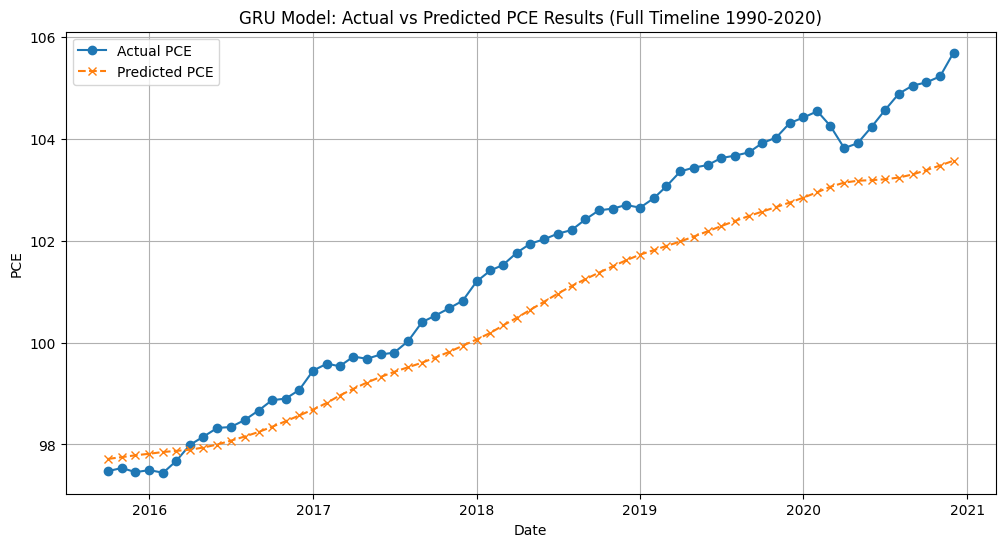

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(comparison_df["Date"], comparison_df["Actual"], label="Actual PCE", marker="o")
plt.plot(comparison_df["Date"], comparison_df["Predicted"], label="Predicted PCE", linestyle="--", marker="x")
plt.title("GRU Model: Actual vs Predicted PCE Results (Full Timeline 1990-2020)")
plt.xlabel("Date")
plt.ylabel("PCE")
plt.legend()
plt.grid()
plt.show()
